In [3]:
import colorthief as ct
import requests
from io import BytesIO
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from skimage.color import rgb2hsv, hsv2rgb

In [4]:
def in_date(soup):
    try:
        return int(soup.find('span').next[1:-1])>2015
    except:
        return False

In [ ]:
# There is duplication here, it would be good to functionalise this.

In [5]:
# Get a big list of the games to identify
games = []
for i in range(1,40):
    url = 'https://boardgamegeek.com/browse/boardgame/page/'+str(i)
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    games.extend([x.find_all('a')[1]['href'] for x in soup.find_all(id="row_") if in_date(x) ])

In [6]:
import json
import statistics
import sys
params = []
total = len(games)
sys.stdout.write('0 of '+str(total))
for game in games:
    try:
        url = 'https://boardgamegeek.com'+game
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        image_url = json.loads(soup.find_all('script')[-1].next)['image']
        colour_thief = ct.ColorThief(BytesIO(requests.get(image_url).content))
        greyscale = statistics.mean(colour_thief.get_color(quality=1))
        age_string = soup.find_all('script')[0].next
        age_pos = age_string.find(',"playerage":"')
        age = int(age_string[age_pos+14:age_pos+20].split('+')[0])
        params.append((greyscale, age))
        sys.stdout.write('\r')
        sys.stdout.write(str(len(params))+' of '+str(total))
        sys.stdout.flush()
    except:
        pass

1135 of 1206

In [20]:
# Get a list of the top games by reviews
pop_games = []
for i in range(1,5):
    url = 'https://boardgamegeek.com/browse/boardgame/page/'+str(i)+'?sort=numvoters&sortdir=desc'
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    pop_games.extend([x.find_all('a')[1]['href'] for x in soup.find_all(id="row_") if in_date(x) ])
print(len(pop_games))

58


In [21]:
import json
import statistics
import sys
pop_params = []
total = len(pop_games)
sys.stdout.write('0 of '+str(total))
for game in pop_games:
    try:
        url = 'https://boardgamegeek.com'+game
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        image_url = json.loads(soup.find_all('script')[-1].next)['image']
        colour_thief = ct.ColorThief(BytesIO(requests.get(image_url).content))
        greyscale = statistics.mean(colour_thief.get_color(quality=1))
        age_string = soup.find_all('script')[0].next
        age_pos = age_string.find(',"playerage":"')
        age = int(age_string[age_pos+14:age_pos+20].split('+')[0])
        pop_params.append((greyscale, age))
        sys.stdout.write('\r')
        sys.stdout.write(str(len(pop_params))+' of '+str(total))
        sys.stdout.flush()
    except:
        pass

58 of 58

In [27]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
ctd = ct.ColorThief('./DarkBox.png')
ctl = ct.ColorThief('./LightBox.png')
gsd = statistics.mean(ctd.get_color(quality=1))
gsl = statistics.mean(ctl.get_color(quality=1))

greyscales, ages = zip(*params)
x = np.array(ages)
y = np.array(greyscales)

pfb = polyfit(x[0:100], y[0:100], 1, full=True)
print(pfb[0])

pf = polyfit(x[100:1000], y[100:1000], 1, full=True)
print(pfb[0])

greyscales, ages = zip(*pop_params)
pop_x = np.array(ages[0:50])
pop_y = np.array(greyscales[0:50])

pop_pf = polyfit(pop_x, pop_y, 1, full=True)
print(pop_pf[0])

[161.76164116  -4.73119505]
[161.76164116  -4.73119505]
[170.0827027   -5.13423423]


Text(0.5,0,'BGG Age Catagory')

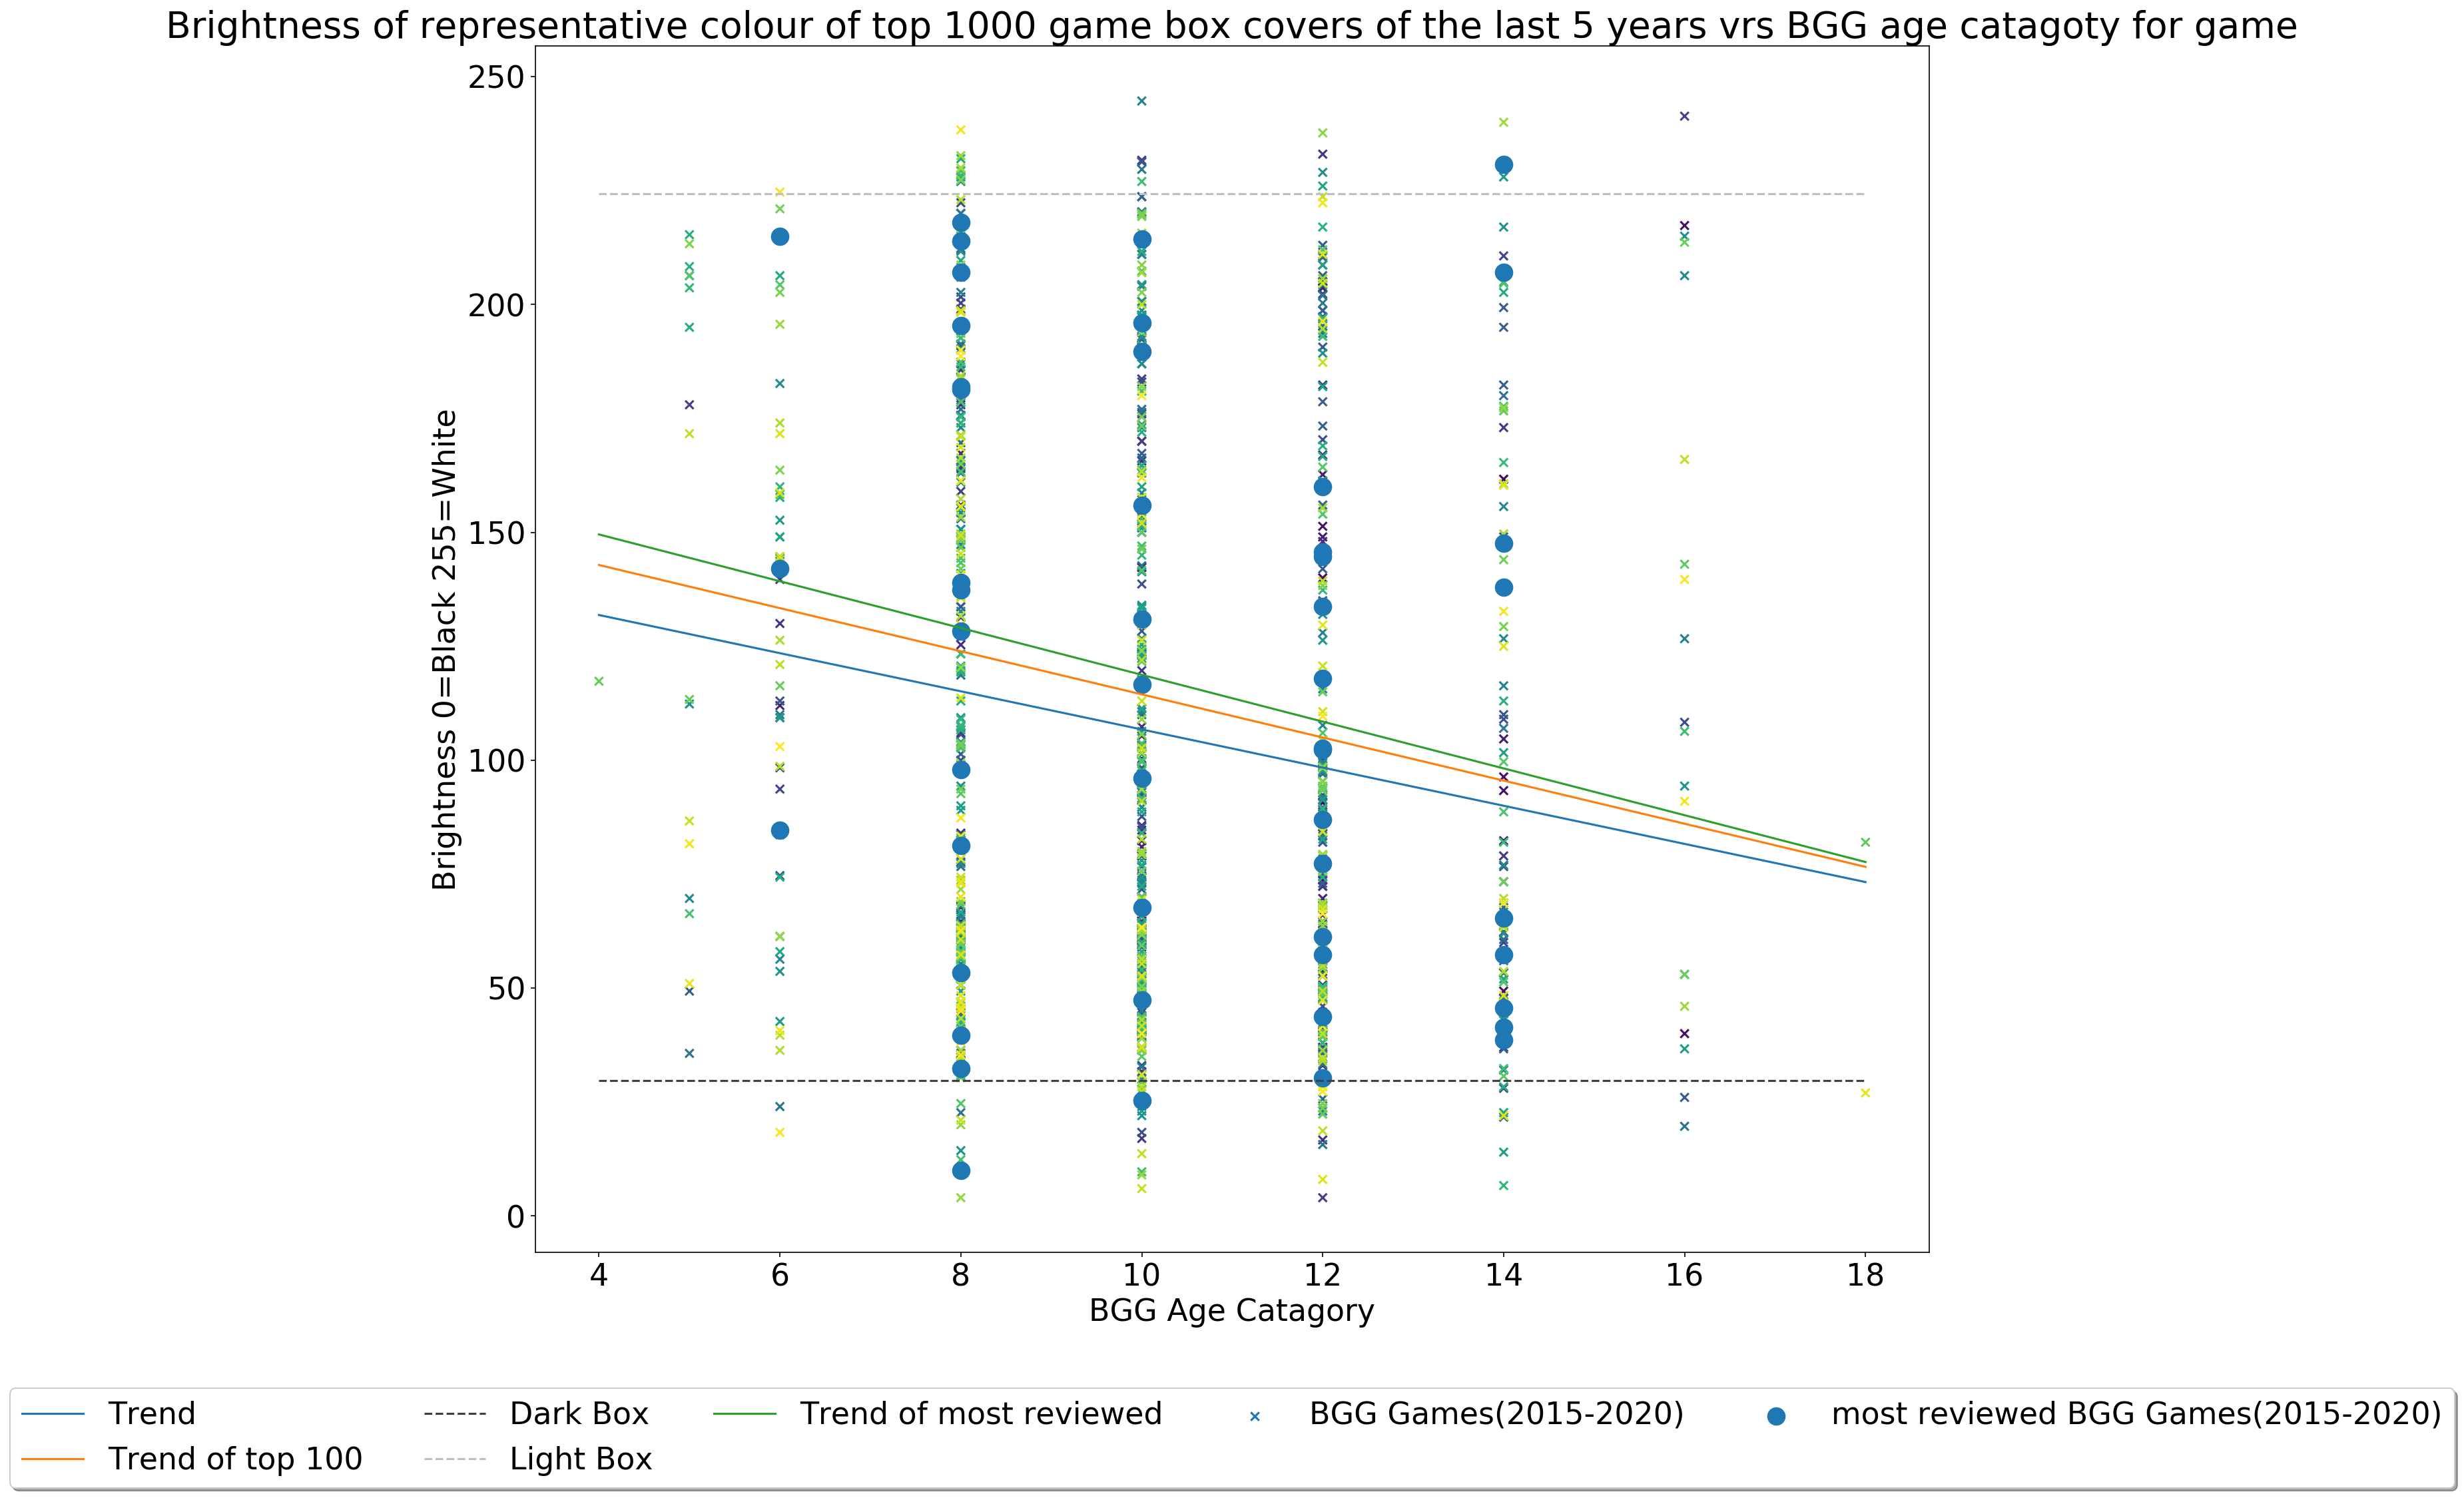

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16), dpi= 150, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.scatter(x, y, c=np.arange(x.shape[0]), marker='x', label='BGG Games(2015-2020)')

plt.plot(np.unique(x), pf[0][0] + pf[0][1] * np.unique(x), '-', label='Trend')
plt.plot(np.unique(x), pfb[0][0] + pfb[0][1] * np.unique(x), '-', label='Trend of top 100')
#plt.plot(np.unique(x), (pf[0][0]+pf[1][2][0]*5) + (pf[0][1]-pf[1][2][1]*5) * np.unique(x), '-')
#plt.plot(np.unique(x), (pf[0][0]-pf[1][2][0]*5) + (pf[0][1]+pf[1][2][1]*5) * np.unique(x), '-')

plt.plot(np.unique(x), gsd + 0 * np.unique(x), '--', color='0.25', label='Dark Box')
plt.plot(np.unique(x), gsl + 0 * np.unique(x), '--', color='0.75', label='Light Box')

plt.scatter(pop_x, pop_y, marker='o', s=150, label='most reviewed BGG Games(2015-2020)')
plt.plot(np.unique(x), pop_pf[0][0] + pop_pf[0][1] * np.unique(x), '-', label='Trend of most reviewed')

plt.title("Brightness of representative colour of top 1000 game box covers of the last 5 years vrs BGG age catagoty for game")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('Brightness 0=Black 255=White')
plt.xlabel('BGG Age Catagory')